In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re
import matplotlib.pyplot as plt
import warnings 
import tensorflow as tf
warnings.filterwarnings(action='ignore')
from tensorflow.keras import preprocessing
import seaborn as sns
import nltk
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import gensim
import spacy
from gensim.models.keyedvectors import KeyedVectors
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')#명사만 추출

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [11]:
train = pd.read_csv('/content/drive/MyDrive/novel/train.csv', encoding = 'utf-8')
test = pd.read_csv('/content/drive/MyDrive/novel/test_x.csv', encoding = 'utf-8')
#sample_submission = pd.read_csv('/content/sample_data/sample_submission.csv', encoding = 'utf-8')

In [12]:
train.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [13]:
test.head()

,index,text
0,0,“Not at all. I think she is one of the most ch...
1,1,"""No,"" replied he, with sudden consciousness, ""..."
2,2,As the lady had stated her intention of scream...
3,3,“And then suddenly in the silence I heard a so...
4,4,His conviction remained unchanged. So far as I...


## 전처리

In [2]:
def alpha_num(text):#기호 제거
    return re.sub(r'[^A-Za-z0-9]', ' ', text)

In [3]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", 
             "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", 
             "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", 
             "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", 
             "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", 
             "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", 
             "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", 
             "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", 
             "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", 
             "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", 
             "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

In [4]:
def remove_stopwords(text):#불용어처리
    final_text=[]
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return ' '.join(final_text)

In [14]:
trn=train.copy()
train['text']=train['text'].str.lower()
test['text']=test['text'].str.lower()
trn['text']=train['text'].apply(alpha_num)
train['text']=train['text'].apply(alpha_num).apply(remove_stopwords)
test['text']=test['text'].apply(alpha_num).apply(remove_stopwords)
train.head()

,index,text,author
0,0,almost choking much much wanted say strange ex...,3
1,1,sister asked suppose,2
2,2,engaged one day walked perusing jane s last le...,1
3,3,captain porch keeping carefully way treacherou...,4
4,4,mercy gentlemen odin flung hands don t write a...,3


In [15]:
test.head()

,index,text
0,0,not think one charming young ladies ever met m...
1,1,no replied sudden consciousness not find canno...
2,2,lady stated intention screaming course screame...
3,3,suddenly silence heard sound sent heart mouth ...
4,4,conviction remained unchanged far know believe...


Text(0, 0.5, 'frequency')

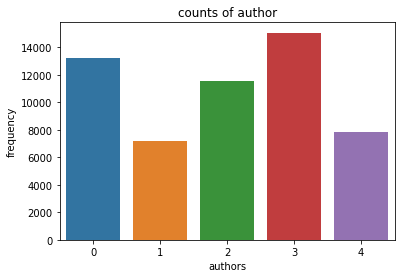

In [ ]:
#작가별 countplot
ax=plt.subplots()
ax=sns.countplot('author',data=train)
ax.set_title('counts of author')
ax.set_xlabel('authors')
ax.set_ylabel('frequency')

0,3번째 작가들의 작품이 많다.

In [ ]:
nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
for token in doc:
    print(token.lemma_)

Apple
be
look
at
buy
U.K.
startup
for
$
1
billion


## EDA (train)

In [ ]:
vocab={}
for sent in train['text']:
    for word in sent.split():
        if word not in vocab.keys():
            vocab[word]=len(vocab)

In [ ]:
print(len(vocab)) #vocab_size는 33707

33707


In [ ]:
#문장 단어 분포도
text_len=[len(s.split()) for s in train['text']]
print('가장 적은 단어 수 : {}'.format(np.min(text_len)))
print('가장 많은 단어 수 : {}'.format(np.max(text_len)))
print('평균 문장 단어 : {}'.format(np.mean(text_len)))

가장 적은 단어 수 : 0
가장 많은 단어 수 : 214
평균 문장 단어 : 20.70854060751836


In [ ]:
text_len[0]

20

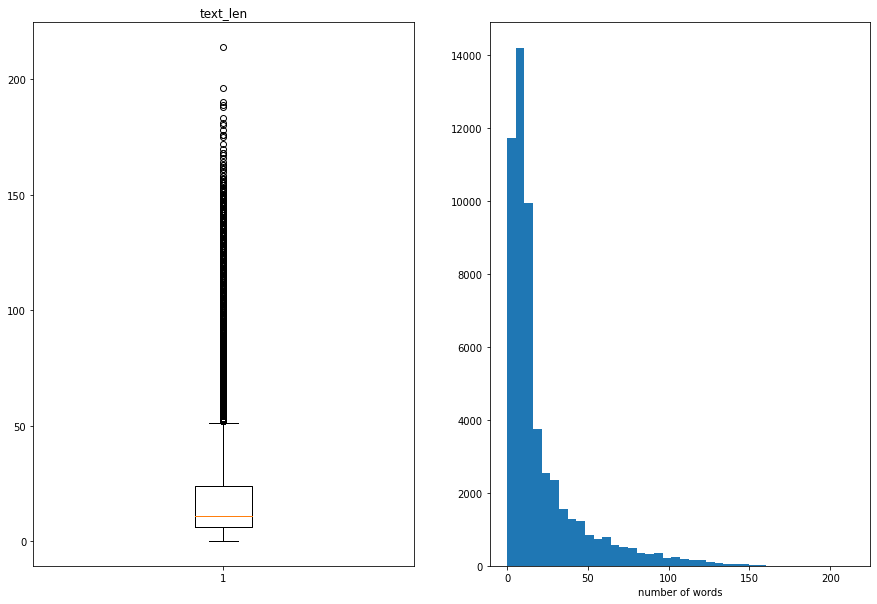

In [ ]:
#문장의 단어 분포
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text_len')

plt.subplot(1,2,2)
plt.hist(text_len,bins=40)
plt.xlabel('number of words')
plt.show()

문장 단어의 개수는 100 이하가 대부분이고 제3사분위수가 50,최소값이 0이고 텍스트의 평균은 20이다. 가장 높은 값은 211이다. 

## 문장길이 분포

In [ ]:
str_len=[len(s) for s in train['text']]
print('가장 짧은 문장 : {}'.format(np.min(str_len)))
print('가장 긴 문장 : {}'.format(np.max(str_len)))
print('평균 문장 : {}'.format(np.mean(str_len)))

가장 짧은 문장 : 0
가장 긴 문장 : 1429
평균 문장 : 133.0049745804406


In [ ]:
trn.head()

,index,text,author
0,0,he was almost choking there was so much so m...,3
1,1,your sister asked for it i suppose,2
2,2,she was engaged one day as she walked in per...,1
3,3,the captain was in the porch keeping himself ...,4
4,4,have mercy gentlemen odin flung up his han...,3


## 작가마다 많이 사용한 단어 분포

In [ ]:
def plot_wordcloud_stopwords(text):#워드클라우딩(불용어 추출)
  def preprocess_text(text):
      corpus=[]
      for a in text:
          tokens = [word for word in word_tokenize(a) if word in stopwords]
          corpus.extend(tokens)
      return corpus
  corpus=preprocess_text(text)
  count = Counter(corpus)
  words = dict(count.most_common())
  wordcloud = WordCloud(
      background_color='white',
      max_words=100,
      max_font_size=50, 
      scale=7,
      random_state=1)
  wordcloud = wordcloud.generate_from_frequencies(words)
  return wordcloud

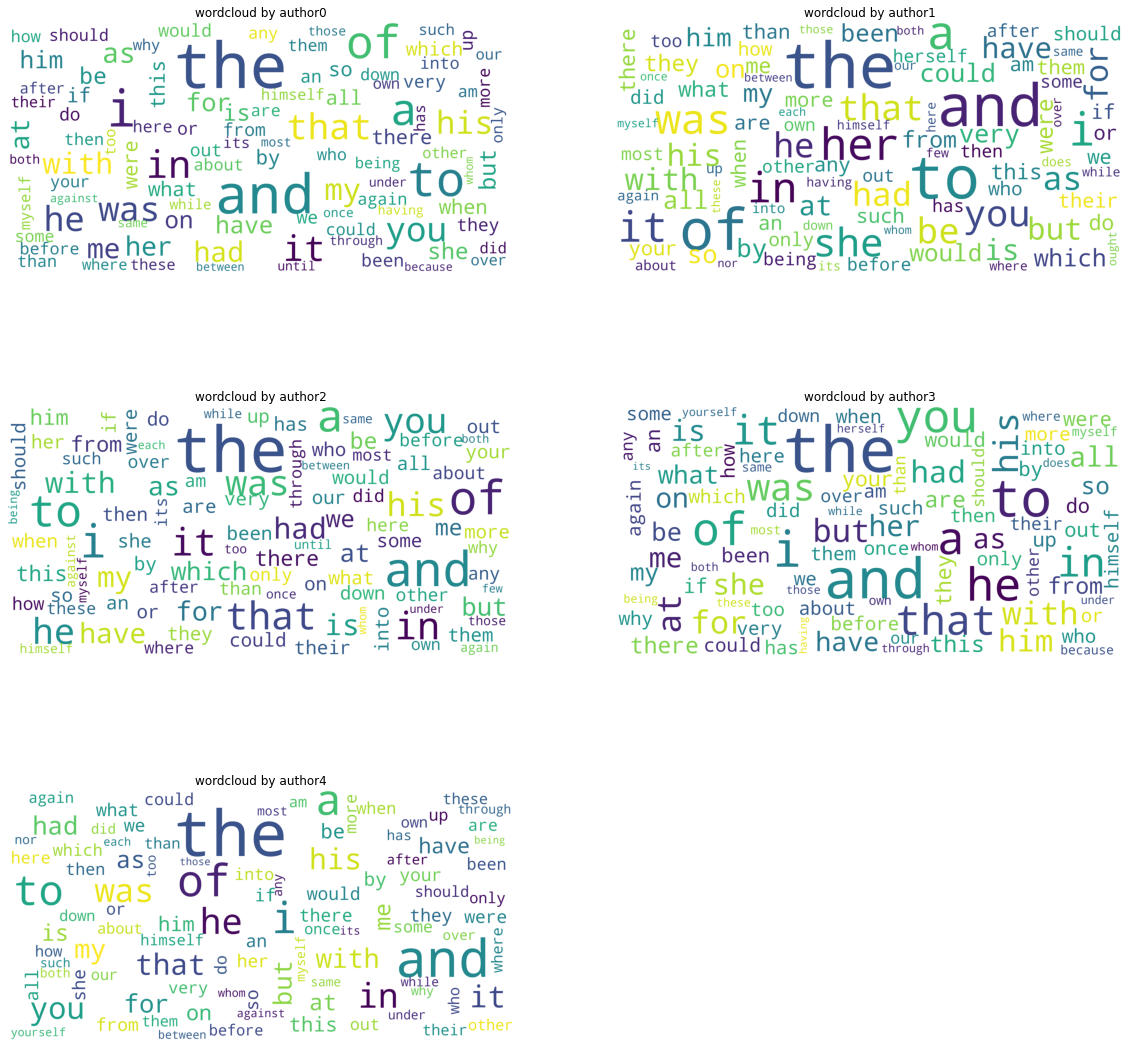

In [ ]:
fig=plt.figure(figsize=(20,20))
rows=3
cols=2
for i in range(5):
    wordcloud=plot_wordcloud_stopwords(trn[trn['author']==i]['text'])
    ax=fig.add_subplot(rows,cols,i+1)
    ax.axis('off')
    ax.set_title('wordcloud by author{}'.format(i))
    ax.imshow(wordcloud)

In [ ]:
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
def plot_wordcloud(text):#워드클라우딩(불용어)
    def preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for a in text:
            tokens = [word for word in word_tokenize(a) if word not in stop]
            tokens=[lem.lemmatize(w) for w in tokens if len(w)>1]
            corpus.extend(tokens)
        return corpus
    corpus=preprocess_text(text)
    count = Counter(corpus)
    words = dict(count.most_common())
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=50, 
        scale=7,
        random_state=1)
    wordcloud = wordcloud.generate_from_frequencies(words)
    return wordcloud

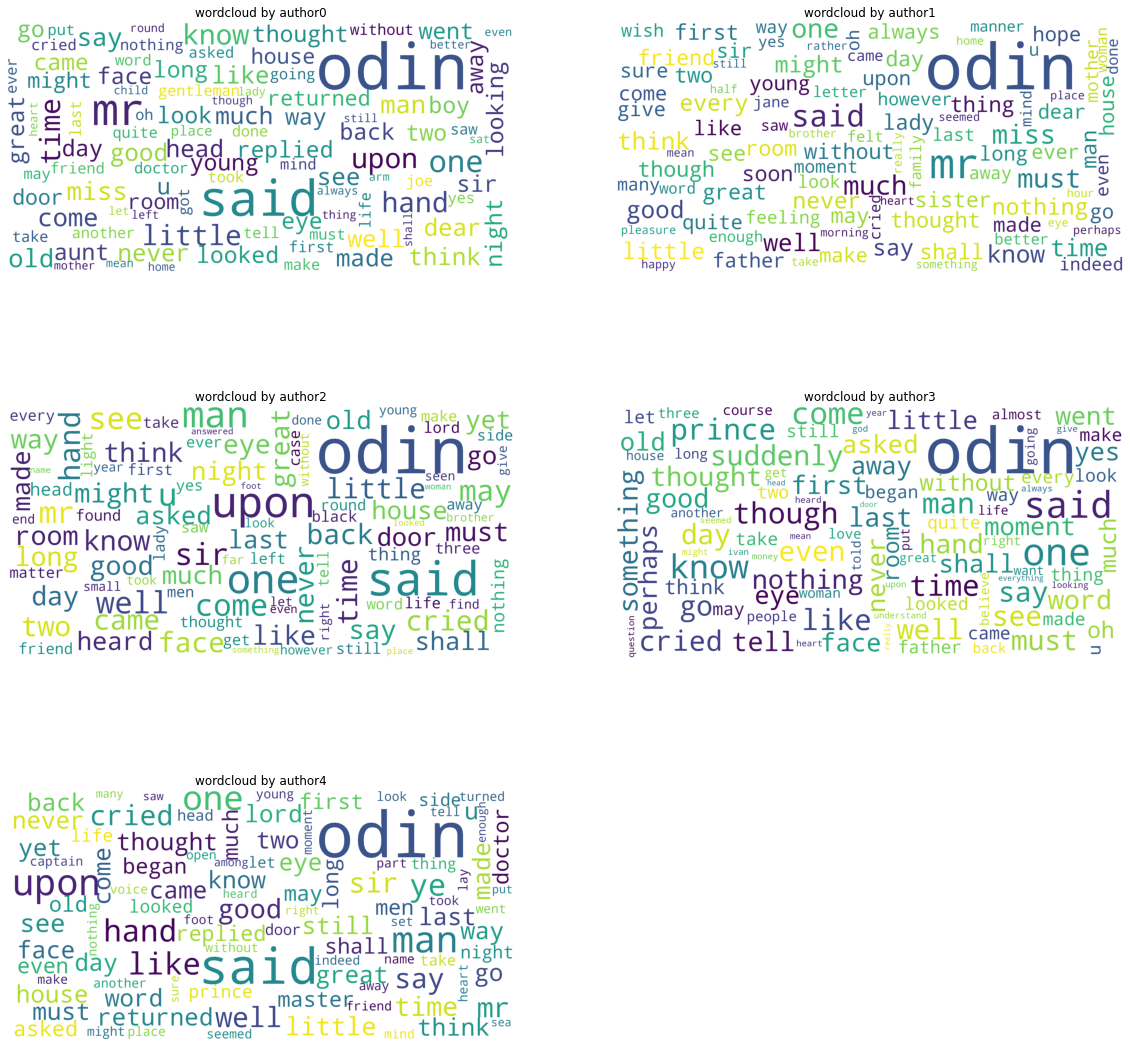

In [ ]:
fig=plt.figure(figsize=(20,20))
rows=3
cols=2
for i in range(5):
    wordcloud=plot_wordcloud(train[train['author']==i]['text'])
    ax=fig.add_subplot(rows,cols,i+1)
    ax.axis('off')
    ax.set_title('wordcloud by author{}'.format(i))
    ax.imshow(wordcloud)

In [ ]:
#명사만 추출
def plot_wordcloud_noun(text,tags=['NN','NLP']):
    def _preprocess_text(text,tags):
        corpus=[]
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if w not in stop]
            words=[lem.lemmatize(w) for w in words if len(w)>1]         
            tagged = nltk.pos_tag(words)
            allnoun = [word for word, pos in tagged if pos in tags]
            corpus.extend(allnoun)
        return corpus
    corpus=_preprocess_text(text,tags)    
    wordcloud = WordCloud(
        background_color='white',
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))
    
    return wordcloud

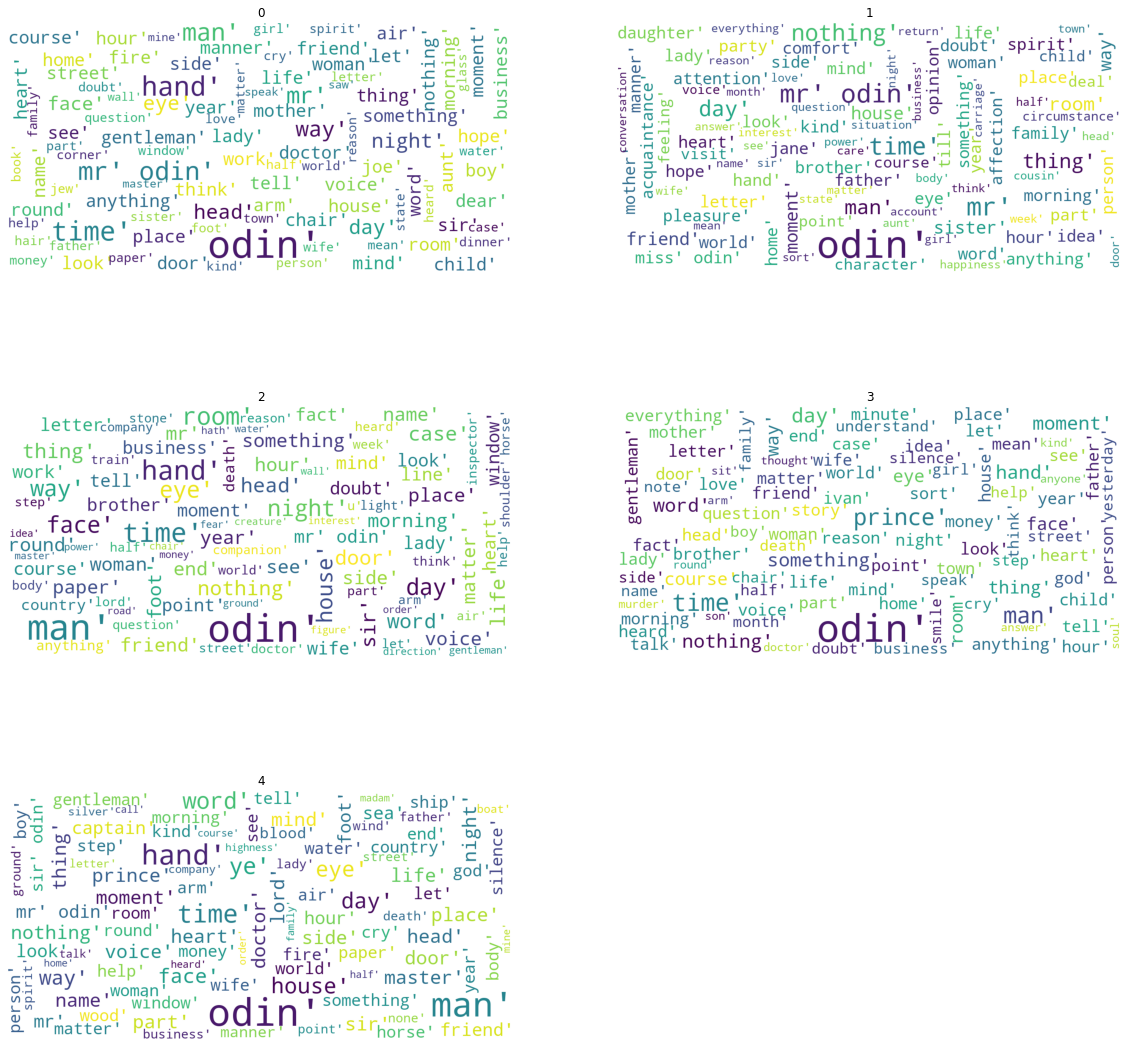

In [ ]:
fig = plt.figure(figsize=(20,20)) # 진짜 오래걸림! nltk로 바꾸면 안될까요?
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(train[train['author']==i]['text'], ['NN','NNP'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)

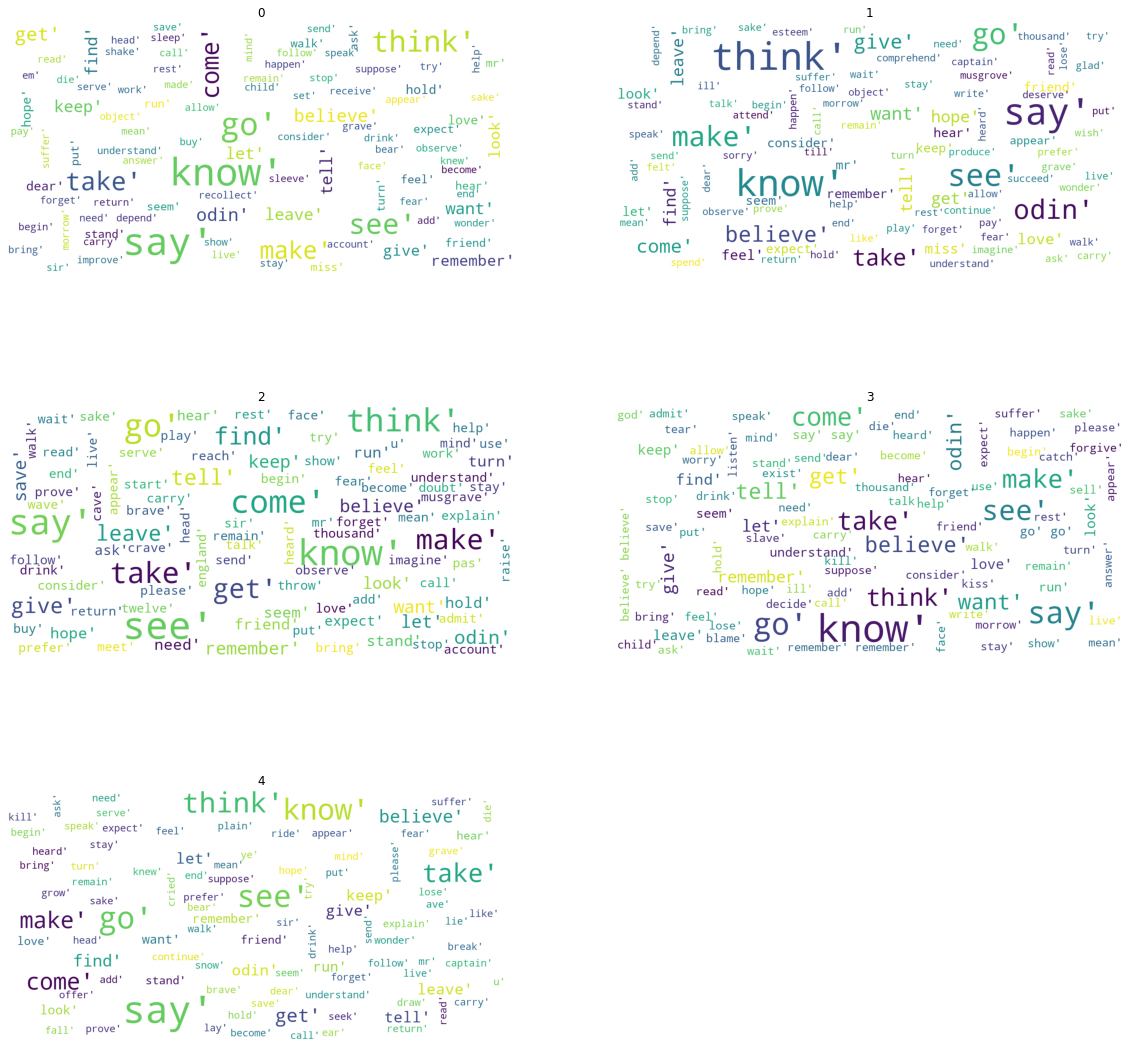

In [ ]:
#동사
fig = plt.figure(figsize=(20,20)) # rows*cols 행렬의 i번째 subplot 생성
rows = 3
cols = 2

for i in range(5):
    wordcloud = plot_wordcloud_noun(train[train['author']==i]['text'], ['VB','VBP'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.axis('off')
    ax.set_title(i)
    ax.imshow(wordcloud)

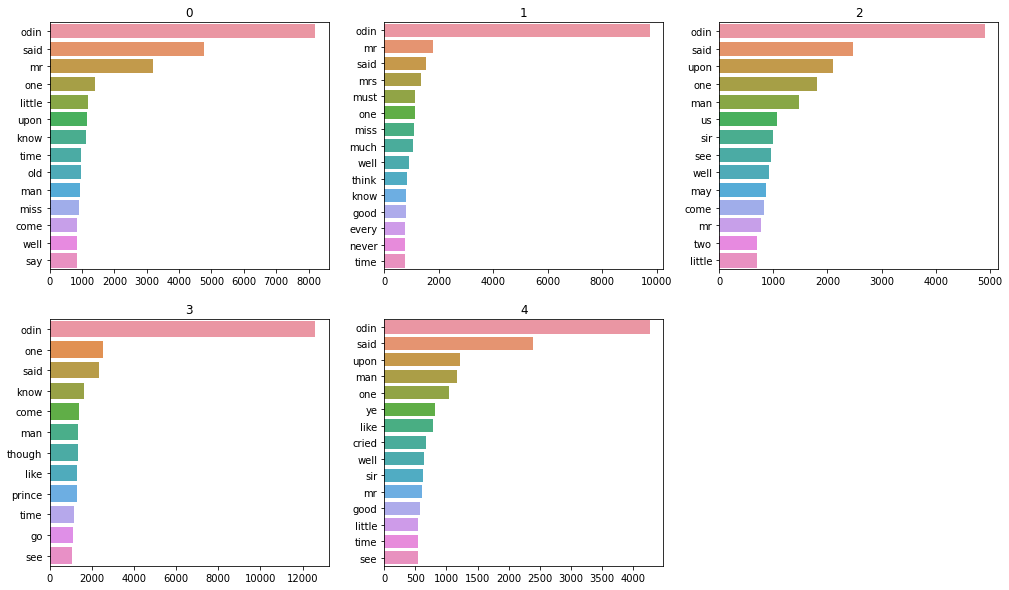

In [ ]:
fig=plt.figure(figsize=(17,10)) #전처리 한 상태에서 제일 많이 나온 단어
rows=2
cols=3
def plot_top_non_stopwords_barchart(text):
  stop=set(stopwords.words('english'))
  new= text.str.split()
  new=new.values.tolist()
  corpus=[word for i in new for word in i]
  counter=Counter(corpus)
  most=counter.most_common()
  x, y=[], []
  for word,count in most[:20]:
      if (word not in stop):
          x.append(word)
          y.append(count)
  return x, y
for i in range(5):
    x,y = plot_top_non_stopwords_barchart(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

## Embedding




### glove+GRU

In [5]:
df_word=pd.read_csv('/content/drive/MyDrive/novel/df_word.csv')
df_word.head()

,token,pos,isalpha,author
0,"he was almost choking . there was so much , so...",PRON AUX ADV ADJ PUNCT PRON AUX ADV ADJ PUNCT ...,True True True True False True True True True ...,3
1,"“ your sister asked for it , i suppose ? ”",PUNCT DET NOUN VERB ADP PRON PUNCT PRON VERB P...,False True True True True True False True True...,2
2,"she was engaged one day as she walked , in per...",PRON AUX VERB NUM NOUN SCONJ PRON VERB PUNCT A...,True True True True True True True True False ...,1
3,"the captain was in the porch , keeping himself...",DET NOUN AUX ADP DET NOUN PUNCT VERB PRON ADV ...,True True True True True True False True True ...,4
4,"“ have mercy , gentlemen ! ” odin flung up his...",PUNCT AUX NOUN PUNCT NOUN PUNCT PUNCT PROPN VE...,False True True False True False False True Tr...,3


In [6]:
words=df_word['token'].apply(alpha_num)

In [13]:
words.head()

0    he was almost choking   there was so much   so...
1             your sister asked for it   i suppose    
2    she was engaged one day as she walked   in per...
3    the captain was in the porch   keeping himself...
4      have mercy   gentlemen     odin flung up his...
Name: token, dtype: object

In [7]:
def text2sequence(train_text,max_len):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(train_text)
    train_x_seq=tokenizer.texts_to_sequences(train_text)
    vocab_size=len(tokenizer.word_index)+1
    print('vocab size:',vocab_size)
    x_train=pad_sequences(train_x_seq,maxlen=max_len)
    return x_train,vocab_size,tokenizer

In [8]:
#엠베딩 사용
def embedding_model(embedding_name):#glove or word2vec or fasttext
  if embedding_name=='glove': #임베딩층은 100
    glove=dict()
    f=open('/content/drive/MyDrive/novel/glove.txt','rt', encoding='UTF8')
    for line in f:
        values=line.split()
        word=values[0]
        vector=np.asarray(values[1:],dtype='float32')
        glove[word]=vector
    f.close()
    return glove
  if embedding_name=='word2vec': #임베딩층은 300
    word2vec=gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/novel/GoogleNews-vectors-negative300.bin.gz',binary=True)
    return word2vec
  if embedding_name=='fasttext':
    fasttext = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/novel/fasttext.vec') #임베딩층은 100
    return fasttext

In [9]:
def embed_matrix(vocab_size,dims,embedding_name,vocabulary):
  embedding_matrix=np.zeros((vocab_size,dims))
  for index,word in enumerate(vocabulary):
      if word in embedding_name:
          embedding_vector=embedding_name[word]
          embedding_matrix[index]=embedding_vector   
      else:
          pass
  return embedding_matrix

In [16]:
y_train = np.array([x for x in train['author']])

In [ ]:
train_x, vocab_size, vectorizer = text2sequence(train['text'], max_len=100)
vocabulary=vectorizer.word_index

vocab size: 33828


In [ ]:
embedding=embedding_model('glove')

In [ ]:
embedding_matrix=embed_matrix(vocab_size,100,embedding,vocabulary)

In [ ]:
def gru_model(vocab_size,dim,embedding_matrix,input_length=100):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size,dim,weights = [embedding_matrix], input_length=input_length),
      tf.keras.layers.GRU(units=30, return_sequences=True),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.GRU(30),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
  ])
  return model

In [ ]:
model=gru_model(vocab_size,100,embedding_matrix,100)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3382800   
_________________________________________________________________
gru (GRU)                    (None, 100, 30)           11880     
_________________________________________________________________
dropout (Dropout)            (None, 100, 30)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                5580      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1

In [ ]:
num_epochs = 20
glove_history = model.fit(train_x,y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25)

Epoch 1/20
1287/1287 [==============================] - 90s 44ms/step - loss: 1.5044 - accuracy: 0.3155 - val_loss: 0.9493 - val_accuracy: 0.6308
Epoch 2/20
1287/1287 [==============================] - 55s 43ms/step - loss: 0.8055 - accuracy: 0.6983 - val_loss: 0.7559 - val_accuracy: 0.7198
Epoch 3/20
1287/1287 [==============================] - 54s 42ms/step - loss: 0.5256 - accuracy: 0.8145 - val_loss: 0.7836 - val_accuracy: 0.7284
Epoch 4/20
1287/1287 [==============================] - 55s 43ms/step - loss: 0.4025 - accuracy: 0.8620 - val_loss: 0.8525 - val_accuracy: 0.7243
Epoch 5/20
1287/1287 [==============================] - 55s 43ms/step - loss: 0.3308 - accuracy: 0.8848 - val_loss: 0.9071 - val_accuracy: 0.7184
Epoch 6/20
1287/1287 [==============================] - 56s 43ms/step - loss: 0.2861 - accuracy: 0.9023 - val_loss: 0.9991 - val_accuracy: 0.7262
Epoch 7/20
1287/1287 [==============================] - 55s 43ms/step - loss: 0.2505 - accuracy: 0.9152 - val_loss: 1.1222 -

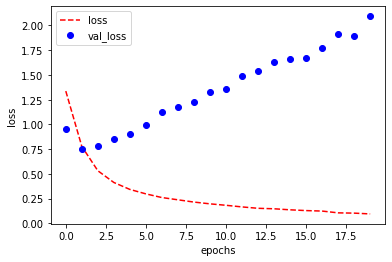

In [ ]:
plt.plot(glove_history.history['loss'],'r--',label='loss')
plt.plot(glove_history.history['val_loss'],'bo',label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
#loss값은 줄어들지만 val_loss는 1로 수렴하는 편

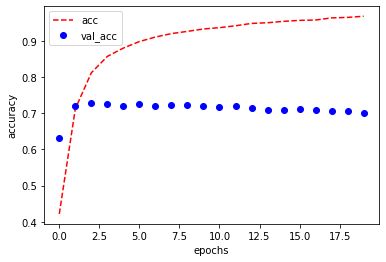

In [ ]:
plt.plot(glove_history.history['accuracy'],'r--',label='acc')
plt.plot(glove_history.history['val_accuracy'],'bo',label='val_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
#acc는 0.9까지 증가하지만 val_loss는 0.7밖에 안된다. 과적합이 많이 생긴다

### word2vec+GRU

In [ ]:
word2vec=embedding_model('word2vec')
word2vec

In [ ]:
embedding_matrix=embed_matrix(vocab_size,300,word2vec,vocabulary)

In [ ]:
embedding_matrix.shape

(33828, 300)

In [ ]:
def gru_model(vocab_size,dim,embedding_matrix,input_length=300):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size,dim,weights = [embedding_matrix], input_length=input_length),
      tf.keras.layers.GRU(units=30, return_sequences=True),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.GRU(30),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
  ])
  return model

In [ ]:
model=gru_model(vocab_size,300,embedding_matrix,input_length=100)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 300)          10148400  
_________________________________________________________________
gru_32 (GRU)                 (None, 100, 30)           29880     
_________________________________________________________________
dropout_32 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
gru_33 (GRU)                 (None, 30)                5580      
_________________________________________________________________
dropout_33 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_33 (Dense)             (None, 5)               

In [ ]:
num_epochs = 20
history = model.fit(train_x, y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25)

Epoch 1/20
1287/1287 [==============================] - 143s 109ms/step - loss: 1.4193 - accuracy: 0.3812 - val_loss: 0.8600 - val_accuracy: 0.6824
Epoch 2/20
1287/1287 [==============================] - 140s 108ms/step - loss: 0.7128 - accuracy: 0.7470 - val_loss: 0.7046 - val_accuracy: 0.7426
Epoch 3/20
1287/1287 [==============================] - 139s 108ms/step - loss: 0.4510 - accuracy: 0.8465 - val_loss: 0.7659 - val_accuracy: 0.7402
Epoch 4/20
1287/1287 [==============================] - 139s 108ms/step - loss: 0.3455 - accuracy: 0.8827 - val_loss: 0.8036 - val_accuracy: 0.7494
Epoch 5/20
1287/1287 [==============================] - 139s 108ms/step - loss: 0.2703 - accuracy: 0.9100 - val_loss: 0.9375 - val_accuracy: 0.7387
Epoch 6/20
1287/1287 [==============================] - 139s 108ms/step - loss: 0.2258 - accuracy: 0.9242 - val_loss: 0.9850 - val_accuracy: 0.7423
Epoch 7/20
1287/1287 [==============================] - 140s 108ms/step - loss: 0.1944 - accuracy: 0.9330 - val_

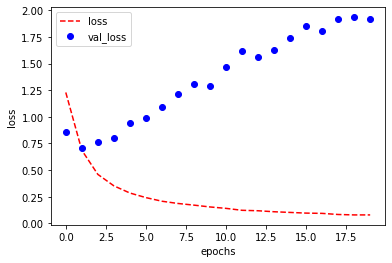

In [ ]:
plt.plot(history.history['loss'],'r--',label='loss')
plt.plot(history.history['val_loss'],'bo',label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
#loss값은 줄어들지만 val_loss는 2로 수렴하는 편

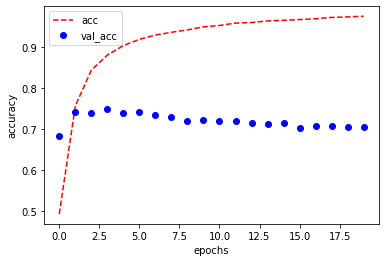

In [ ]:
plt.plot(history.history['accuracy'],'r--',label='acc')
plt.plot(history.history['val_accuracy'],'bo',label='val_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
#acc는 0.9까지 증가하지만 val_loss는 0.7밖에 안된다. 과적합이 많이 생긴다

### Fasttext +GRU

In [ ]:
embedding=embedding_model('fasttext')

In [ ]:
embedding_matrix=embed_matrix(vocab_size,100,embedding,vocabulary)

In [ ]:
embedding_matrix.shape

(33828, 100)

In [ ]:
model=gru_model(vocab_size,100,embedding_matrix,input_length=100)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 100, 100)          3382800   
_________________________________________________________________
gru_36 (GRU)                 (None, 100, 30)           11880     
_________________________________________________________________
dropout_36 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
gru_37 (GRU)                 (None, 30)                5580      
_________________________________________________________________
dropout_37 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 32)                992       
_________________________________________________________________
dense_37 (Dense)             (None, 5)               

In [ ]:
num_epochs = 20
fast_history = model.fit(train_x, y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25)

Epoch 1/20
1287/1287 [==============================] - 60s 44ms/step - loss: 1.4265 - accuracy: 0.3728 - val_loss: 0.8972 - val_accuracy: 0.6432
Epoch 2/20
1287/1287 [==============================] - 56s 43ms/step - loss: 0.7948 - accuracy: 0.6949 - val_loss: 0.7887 - val_accuracy: 0.7076
Epoch 3/20
1287/1287 [==============================] - 56s 43ms/step - loss: 0.5335 - accuracy: 0.8143 - val_loss: 0.7475 - val_accuracy: 0.7411
Epoch 4/20
1287/1287 [==============================] - 56s 43ms/step - loss: 0.3966 - accuracy: 0.8665 - val_loss: 0.7991 - val_accuracy: 0.7397
Epoch 5/20
1287/1287 [==============================] - 56s 43ms/step - loss: 0.3080 - accuracy: 0.8980 - val_loss: 0.9070 - val_accuracy: 0.7361
Epoch 6/20
1287/1287 [==============================] - 56s 44ms/step - loss: 0.2607 - accuracy: 0.9123 - val_loss: 0.9691 - val_accuracy: 0.7337
Epoch 7/20
1287/1287 [==============================] - 56s 43ms/step - loss: 0.2292 - accuracy: 0.9247 - val_loss: 0.9979 -

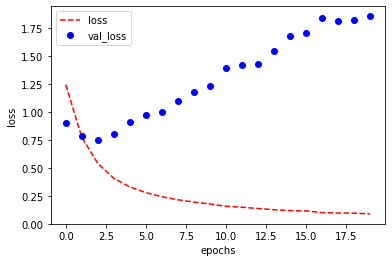

In [ ]:
plt.plot(fast_history.history['loss'],'r--',label='loss')
plt.plot(fast_history.history['val_loss'],'bo',label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

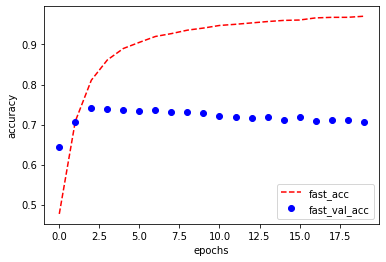

In [ ]:
plt.plot(fast_history.history['accuracy'],'r--',label='fast_acc')
plt.plot(fast_history.history['val_accuracy'],'bo',label='fast_val_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

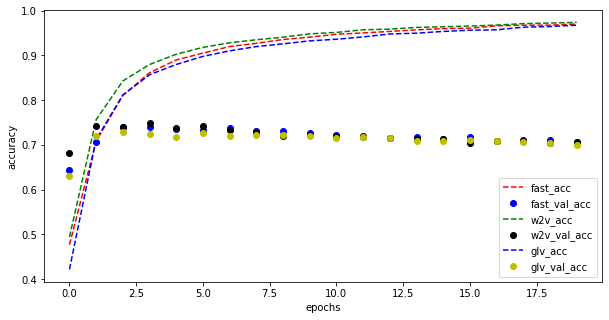

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(fast_history.history['accuracy'],'r--',label='fast_acc')
plt.plot(fast_history.history['val_accuracy'],'bo',label='fast_val_acc')
plt.plot(history.history['accuracy'],'g--',label='w2v_acc')
plt.plot(history.history['val_accuracy'],'ko',label='w2v_val_acc')
plt.plot(glove_history.history['accuracy'],'b--',label='glv_acc')
plt.plot(glove_history.history['val_accuracy'],'yo',label='glv_val_acc')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

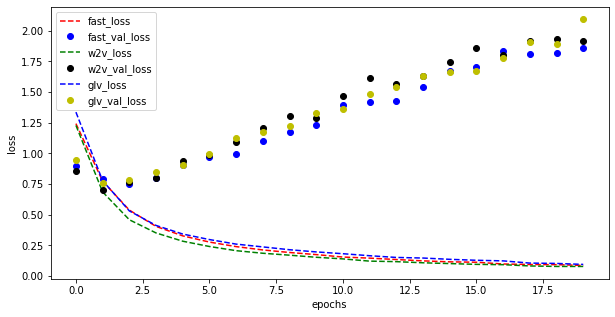

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(fast_history.history['loss'],'r--',label='fast_loss')
plt.plot(fast_history.history['val_loss'],'bo',label='fast_val_loss')
plt.plot(history.history['loss'],'g--',label='w2v_loss')
plt.plot(history.history['val_loss'],'ko',label='w2v_val_loss')
plt.plot(glove_history.history['loss'],'b--',label='glv_loss')
plt.plot(glove_history.history['val_loss'],'yo',label='glv_val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

## LearningRateScheduler,batchNormalization 적용

In [ ]:
def embedding_model(embedding_name):#glove or word2vec or fasttext
  if embedding_name=='glove': #임베딩층은 100
    glove=dict()
    f=open('/content/drive/MyDrive/novel/glove.txt','rt', encoding='UTF8')
    for line in f:
        values=line.split()
        word=values[0]
        vector=np.asarray(values[1:],dtype='float32')
        glove[word]=vector
    f.close()
    return glove
  if embedding_name=='word2vec': #임베딩층은 300
    word2vec=gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/novel/GoogleNews-vectors-negative300.bin.gz',binary=True)
    return word2vec
  if embedding_name=='fasttext':
    fasttext = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/novel/fasttext.vec') #임베딩층은 100
    return fasttext

### glove

In [19]:
glove=embedding_model('glove')
train_x, vocab_size, vectorizer = text2sequence(words, max_len=100)
vocabulary=vectorizer.word_index
embedding_matrix=embed_matrix(vocab_size,100,glove,vocabulary)

vocab size: 33817


In [ ]:
def gru_callback_model(vocab_size,dim,embedding_matrix,input_length):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size,dim,weights = [embedding_matrix], input_length=input_length),
      tf.keras.layers.GRU(units=30, return_sequences=True),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.GRU(30),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
  ])
  return model
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
model=gru_callback_model(vocab_size,100,embedding_matrix,100)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          3381700   
_________________________________________________________________
gru_12 (GRU)                 (None, 100, 30)           11880     
_________________________________________________________________
dropout_12 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
gru_13 (GRU)                 (None, 30)                5580      
_________________________________________________________________
batch_normalization_6 (Batch (None, 30)                120       
_________________________________________________________________
dropout_13 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [ ]:
num_epochs = 15
glove_cb_history = model.fit(train_x, y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25,callbacks=[callback])

Epoch 1/15
1287/1287 [==============================] - 54s 40ms/step - loss: 1.6801 - accuracy: 0.2604 - val_loss: 1.4877 - val_accuracy: 0.3319
Epoch 2/15
1287/1287 [==============================] - 51s 40ms/step - loss: 1.1897 - accuracy: 0.5045 - val_loss: 0.8646 - val_accuracy: 0.6672
Epoch 3/15
1287/1287 [==============================] - 51s 40ms/step - loss: 0.7301 - accuracy: 0.7343 - val_loss: 0.7804 - val_accuracy: 0.7198
Epoch 4/15
1287/1287 [==============================] - 52s 40ms/step - loss: 0.5133 - accuracy: 0.8222 - val_loss: 0.8056 - val_accuracy: 0.7257
Epoch 5/15
1287/1287 [==============================] - 52s 40ms/step - loss: 0.4082 - accuracy: 0.8577 - val_loss: 0.8563 - val_accuracy: 0.7254
Epoch 6/15
1287/1287 [==============================] - 53s 41ms/step - loss: 0.3501 - accuracy: 0.8802 - val_loss: 0.9493 - val_accuracy: 0.7243
Epoch 7/15
1287/1287 [==============================] - 52s 40ms/step - loss: 0.3178 - accuracy: 0.8912 - val_loss: 1.0209 -

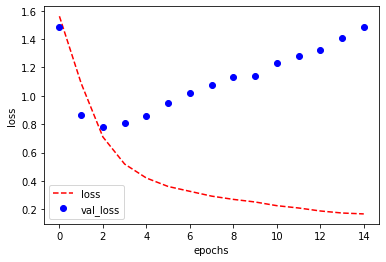

In [ ]:
plt.plot(glove_cb_history.history['loss'],'r--',label='loss')
plt.plot(glove_cb_history.history['val_loss'],'bo',label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

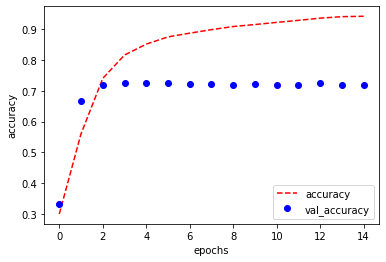

In [ ]:
plt.plot(glove_cb_history.history['accuracy'],'r--',label='accuracy')
plt.plot(glove_cb_history.history['val_accuracy'],'bo',label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()
#acc는 0.9까지 증가하지만 val_loss는 0.7밖에 안된다. 과적합이 많이 생긴다

In [ ]:
from keras.models import load_model
model.save('/content/drive/MyDrive/novel/gru_glove_callback_model.h5')#max_len=100,embedding=100인 모델로,w2v 쓰려면 embedding을 300으로 바꿔야 한다

In [ ]:
model=load_model('/content/drive/MyDrive/novel/gru_glove_callback_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3381700   
_________________________________________________________________
gru (GRU)                    (None, 100, 30)           11880     
_________________________________________________________________
dropout (Dropout)            (None, 100, 30)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                5580      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                9

### word2vec

In [ ]:
word2vec=embedding_model('word2vec')
train_x, vocab_size, vectorizer = text2sequence(words, max_len=100)
vocabulary=vectorizer.word_index
embedding_matrix=embed_matrix(vocab_size,300,word2vec,vocabulary)

vocab size: 33817


In [ ]:
model=gru_callback_model(vocab_size,300,embedding_matrix,100)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 300)          10145100  
_________________________________________________________________
gru_8 (GRU)                  (None, 100, 30)           29880     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 30)           0         
_________________________________________________________________
gru_9 (GRU)                  (None, 30)                5580      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30)                120       
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

In [ ]:
num_epochs = 15
w2v_cb_history = model.fit(train_x, y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25,callbacks=[callback])

Epoch 1/15
1287/1287 [==============================] - 167s 103ms/step - loss: 1.5565 - accuracy: 0.3254 - val_loss: 0.9819 - val_accuracy: 0.6175
Epoch 2/15
1287/1287 [==============================] - 132s 103ms/step - loss: 0.8691 - accuracy: 0.6710 - val_loss: 0.7501 - val_accuracy: 0.7226
Epoch 3/15
1287/1287 [==============================] - 132s 103ms/step - loss: 0.5746 - accuracy: 0.7943 - val_loss: 0.7364 - val_accuracy: 0.7403
Epoch 4/15
1287/1287 [==============================] - 133s 103ms/step - loss: 0.4339 - accuracy: 0.8507 - val_loss: 0.8112 - val_accuracy: 0.7388
Epoch 5/15
1287/1287 [==============================] - 131s 102ms/step - loss: 0.3522 - accuracy: 0.8817 - val_loss: 0.8853 - val_accuracy: 0.7283
Epoch 6/15
1287/1287 [==============================] - 131s 102ms/step - loss: 0.3051 - accuracy: 0.8970 - val_loss: 0.9376 - val_accuracy: 0.7310
Epoch 7/15
1287/1287 [==============================] - 137s 106ms/step - loss: 0.2739 - accuracy: 0.9078 - val_

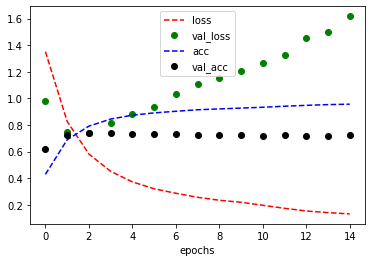

In [ ]:
plt.plot(w2v_cb_history.history['loss'],'r--',label='loss')
plt.plot(w2v_cb_history.history['val_loss'],'go',label='val_loss')
plt.plot(w2v_cb_history.history['accuracy'],'b--',label='acc')
plt.plot(w2v_cb_history.history['val_accuracy'],'ko',label='val_acc')

plt.legend()
plt.xlabel('epochs')

plt.show()
#w2v은 정확도에서는 큰 차이가 없지만 loss에서는 크게 차이가 있다.

In [ ]:
model.save('/content/drive/MyDrive/novel/gru_w2v_callback_model.h5')

### fasttext

In [ ]:
fasttext=embedding_model('fasttext')
train_x, vocab_size, vectorizer = text2sequence(words, max_len=100)
vocabulary=vectorizer.word_index
embedding_matrix=embed_matrix(vocab_size,100,fasttext,vocabulary)
model=gru_callback_model(vocab_size,100,embedding_matrix,100)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

vocab size: 33817
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          3381700   
_________________________________________________________________
gru_10 (GRU)                 (None, 100, 30)           11880     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100, 30)           0         
_________________________________________________________________
gru_11 (GRU)                 (None, 30)                5580      
_________________________________________________________________
batch_normalization_5 (Batch (None, 30)                120       
_________________________________________________________________
dropout_11 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 

In [21]:
num_epochs = 15
ft_cb_history = model.fit(train_x, y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25,callbacks=[callback])

Epoch 1/15


KeyboardInterrupt: ignored

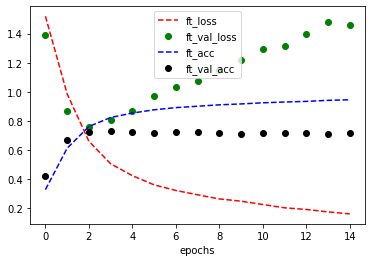

In [ ]:
plt.plot(ft_cb_history.history['loss'],'r--',label='ft_loss')
plt.plot(ft_cb_history.history['val_loss'],'go',label='ft_val_loss')
plt.plot(ft_cb_history.history['accuracy'],'b--',label='ft_acc')
plt.plot(ft_cb_history.history['val_accuracy'],'ko',label='ft_val_acc')
plt.legend()
plt.xlabel('epochs')

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/novel/gru_ft_callback_model.h5')

### 적용 결과

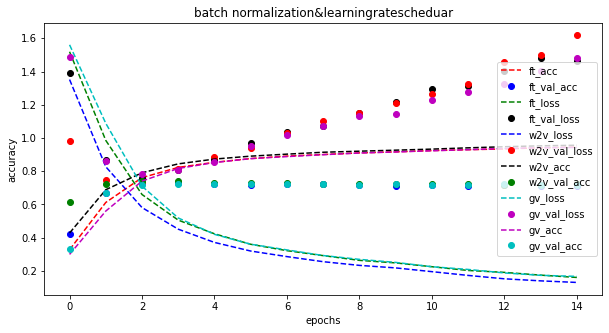

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(ft_cb_history.history['accuracy'],'r--',label='ft_acc')
plt.plot(ft_cb_history.history['val_accuracy'],'bo',label='ft_val_acc')
plt.plot(ft_cb_history.history['loss'],'g--',label='ft_loss')
plt.plot(ft_cb_history.history['val_loss'],'ko',label='ft_val_loss')
plt.plot(w2v_cb_history.history['loss'],'b--',label='w2v_loss')
plt.plot(w2v_cb_history.history['val_loss'],'ro',label='w2v_val_loss')
plt.plot(w2v_cb_history.history['accuracy'],'k--',label='w2v_acc')
plt.plot(w2v_cb_history.history['val_accuracy'],'go',label='w2v_val_acc')
plt.plot(glove_cb_history.history['loss'],'c--',label='gv_loss')
plt.plot(glove_cb_history.history['val_loss'],'mo',label='gv_val_loss')
plt.plot(glove_cb_history.history['accuracy'],'m--',label='gv_acc')
plt.plot(glove_cb_history.history['val_accuracy'],'co',label='gv_val_acc')
plt.legend()
plt.title('batch normalization&learningratescheduar')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

loss: 0.1647 - accuracy: 0.9439 - val_loss: 1.4836 - val_accuracy: 0.7192 (glove)

loss: 0.1314 - accuracy: 0.9562 - val_loss: 1.6176 - val_accuracy: 0.7223 (word2vec)

loss: 0.1538 - accuracy: 0.9468 - val_loss: 1.4609 - val_accuracy: 0.7137 (fasttext)



## BN+Gru (no dropout)

### glove

In [17]:
glove=embedding_model('glove')
train_x, vocab_size, vectorizer = text2sequence(words, max_len=100)
vocabulary=vectorizer.word_index
embedding_matrix=embed_matrix(vocab_size,100,glove,vocabulary)

vocab size: 33817


In [18]:
def gru_callback_bn_model(vocab_size,dim,embedding_matrix,input_length):
  model = tf.keras.Sequential([
      tf.keras.layers.Embedding(vocab_size,dim,weights = [embedding_matrix], input_length=input_length),
      tf.keras.layers.GRU(units=30, return_sequences=True),
      tf.keras.layers.GRU(30),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(32, activation='relu'),
      tf.keras.layers.Dense(5, activation='softmax')
  ])
  return model
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)
model=gru_callback_bn_model(vocab_size,100,embedding_matrix,100)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3381700   
_________________________________________________________________
gru (GRU)                    (None, 100, 30)           11880     
_________________________________________________________________
gru_1 (GRU)                  (None, 30)                5580      
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dense (Dense)                (None, 32)                992       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 3,400,437
Trainable params: 3,400,377
Non-trainable params: 60
_____________________________________________

In [19]:
num_epochs = 15
gv_bn_history = model.fit(train_x, y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25,callbacks=[callback])

Epoch 1/15
1287/1287 [==============================] - 60s 43ms/step - loss: 1.5028 - accuracy: 0.3396 - val_loss: 1.0747 - val_accuracy: 0.5770
Epoch 2/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.6988 - accuracy: 0.7405 - val_loss: 0.9373 - val_accuracy: 0.6504
Epoch 3/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.4175 - accuracy: 0.8506 - val_loss: 0.8191 - val_accuracy: 0.7188
Epoch 4/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.3154 - accuracy: 0.8872 - val_loss: 0.8905 - val_accuracy: 0.7193
Epoch 5/15
1287/1287 [==============================] - 55s 43ms/step - loss: 0.2630 - accuracy: 0.9037 - val_loss: 1.0156 - val_accuracy: 0.7131
Epoch 6/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.2249 - accuracy: 0.9163 - val_loss: 1.1023 - val_accuracy: 0.7163
Epoch 7/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.1968 - accuracy: 0.9269 - val_loss: 1.1526 -

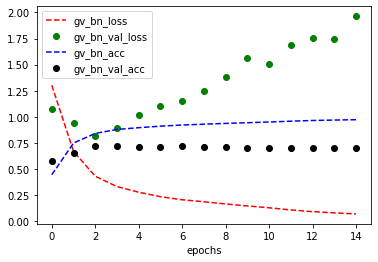

In [20]:
plt.plot(gv_bn_history.history['loss'],'r--',label='gv_bn_loss')
plt.plot(gv_bn_history.history['val_loss'],'go',label='gv_bn_val_loss')
plt.plot(gv_bn_history.history['accuracy'],'b--',label='gv_bn_acc')
plt.plot(gv_bn_history.history['val_accuracy'],'ko',label='gv_bn_val_acc')
plt.legend()
plt.xlabel('epochs')

plt.show()

In [21]:
model.save('/content/drive/MyDrive/novel/gv_bn_model.h5')

### word2vec

In [22]:
word2vec=embedding_model('word2vec')
train_x, vocab_size, vectorizer = text2sequence(words, max_len=100)
vocabulary=vectorizer.word_index
embedding_matrix=embed_matrix(vocab_size,300,word2vec,vocabulary)

vocab size: 33817


In [28]:
model=gru_callback_bn_model(vocab_size,300,embedding_matrix,100)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 300)          10145100  
_________________________________________________________________
gru_6 (GRU)                  (None, 100, 30)           29880     
_________________________________________________________________
gru_7 (GRU)                  (None, 30)                5580      
_________________________________________________________________
batch_normalization_3 (Batch (None, 30)                120       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 165       
Total params: 10,181,837
Trainable params: 10,181,777
Non-trainable params: 60
_________________________________________

In [29]:
num_epochs = 15
w2v_bn_history = model.fit(train_x, y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25,callbacks=[callback])

Epoch 1/15
1287/1287 [==============================] - 142s 108ms/step - loss: 1.3608 - accuracy: 0.4190 - val_loss: 1.3533 - val_accuracy: 0.4550
Epoch 2/15
1287/1287 [==============================] - 137s 106ms/step - loss: 0.5816 - accuracy: 0.7877 - val_loss: 0.9843 - val_accuracy: 0.6757
Epoch 3/15
1287/1287 [==============================] - 136s 106ms/step - loss: 0.3629 - accuracy: 0.8704 - val_loss: 0.8001 - val_accuracy: 0.7322
Epoch 4/15
1287/1287 [==============================] - 135s 105ms/step - loss: 0.2714 - accuracy: 0.9004 - val_loss: 0.9685 - val_accuracy: 0.7187
Epoch 5/15
1287/1287 [==============================] - 135s 105ms/step - loss: 0.2164 - accuracy: 0.9207 - val_loss: 1.1280 - val_accuracy: 0.7012
Epoch 6/15
1287/1287 [==============================] - 134s 104ms/step - loss: 0.1839 - accuracy: 0.9325 - val_loss: 1.0997 - val_accuracy: 0.7235
Epoch 7/15
1287/1287 [==============================] - 133s 103ms/step - loss: 0.1543 - accuracy: 0.9436 - val_

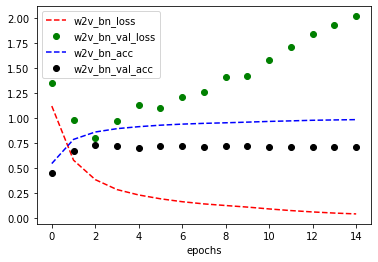

In [30]:
plt.plot(w2v_bn_history.history['loss'],'r--',label='w2v_bn_loss')
plt.plot(w2v_bn_history.history['val_loss'],'go',label='w2v_bn_val_loss')
plt.plot(w2v_bn_history.history['accuracy'],'b--',label='w2v_bn_acc')
plt.plot(w2v_bn_history.history['val_accuracy'],'ko',label='w2v_bn_val_acc')
plt.legend()
plt.xlabel('epochs')

plt.show()

In [31]:
model.save('/content/drive/MyDrive/novel/w2v_bn_model.h5')

In [32]:
fasttext=embedding_model('fasttext')
train_x, vocab_size, vectorizer = text2sequence(words, max_len=100)
vocabulary=vectorizer.word_index
embedding_matrix=embed_matrix(vocab_size,100,fasttext,vocabulary)
model=gru_callback_bn_model(vocab_size,100,embedding_matrix,100)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

vocab size: 33817
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          3381700   
_________________________________________________________________
gru_8 (GRU)                  (None, 100, 30)           11880     
_________________________________________________________________
gru_9 (GRU)                  (None, 30)                5580      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30)                120       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 165       
Total params: 3,400,437
Trainable params: 3,400,377
Non-trainable params: 60
_________________________

In [33]:
num_epochs = 15
fx_bn_history = model.fit(train_x, y_train, 
                    epochs=num_epochs, 
                    validation_split=0.25,callbacks=[callback])

Epoch 1/15
1287/1287 [==============================] - 58s 43ms/step - loss: 1.4364 - accuracy: 0.3741 - val_loss: 2.5976 - val_accuracy: 0.4246
Epoch 2/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.6756 - accuracy: 0.7473 - val_loss: 1.0469 - val_accuracy: 0.6342
Epoch 3/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.4375 - accuracy: 0.8421 - val_loss: 1.2281 - val_accuracy: 0.6267
Epoch 4/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.3384 - accuracy: 0.8774 - val_loss: 1.3134 - val_accuracy: 0.6353
Epoch 5/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.2872 - accuracy: 0.8941 - val_loss: 1.2288 - val_accuracy: 0.6913
Epoch 6/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.2403 - accuracy: 0.9130 - val_loss: 1.1168 - val_accuracy: 0.6988
Epoch 7/15
1287/1287 [==============================] - 54s 42ms/step - loss: 0.2137 - accuracy: 0.9232 - val_loss: 1.1510 -

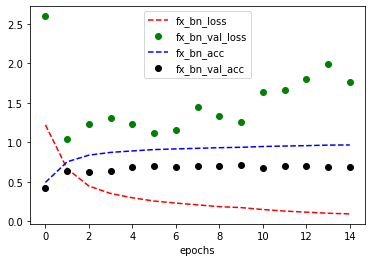

In [34]:
plt.plot(fx_bn_history.history['loss'],'r--',label='fx_bn_loss')
plt.plot(fx_bn_history.history['val_loss'],'go',label='fx_bn_val_loss')
plt.plot(fx_bn_history.history['accuracy'],'b--',label='fx_bn_acc')
plt.plot(fx_bn_history.history['val_accuracy'],'ko',label='fx_bn_val_acc')
plt.legend()
plt.xlabel('epochs')

plt.show()

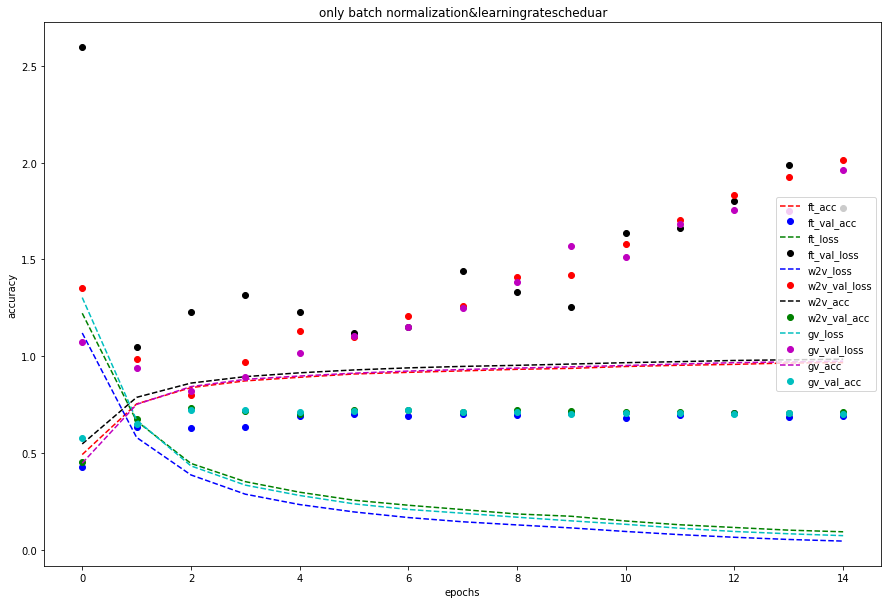

In [37]:
plt.figure(figsize=(15,10))
plt.plot(fx_bn_history.history['accuracy'],'r--',label='ft_acc')
plt.plot(fx_bn_history.history['val_accuracy'],'bo',label='ft_val_acc')
plt.plot(fx_bn_history.history['loss'],'g--',label='ft_loss')
plt.plot(fx_bn_history.history['val_loss'],'ko',label='ft_val_loss')
plt.plot(w2v_bn_history.history['loss'],'b--',label='w2v_loss')
plt.plot(w2v_bn_history.history['val_loss'],'ro',label='w2v_val_loss')
plt.plot(w2v_bn_history.history['accuracy'],'k--',label='w2v_acc')
plt.plot(w2v_bn_history.history['val_accuracy'],'go',label='w2v_val_acc')
plt.plot(gv_bn_history.history['loss'],'c--',label='gv_loss')
plt.plot(gv_bn_history.history['val_loss'],'mo',label='gv_val_loss')
plt.plot(gv_bn_history.history['accuracy'],'m--',label='gv_acc')
plt.plot(gv_bn_history.history['val_accuracy'],'co',label='gv_val_acc')
plt.legend(loc='right')
plt.title('only batch normalization&learningratescheduar')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()